# Fully connected feedforward network implementing a loss mask

In [ ]:
import torchmetrics.classification
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0

In [ ]:
print(cuda.get_device_name(cuda.current_device()))


NVIDIA GeForce RTX 3060 Ti


In [ ]:
import torch

In [ ]:
DEVICE = torch.device("cuda")
SEED = 76436278

torch.manual_seed(SEED)

checkpoint = torch.load('./model.pt')
site = ["DRIAMS-B"]

### Load the Dataset

In [ ]:
from src.maldi2resistance.data.driams import Driams

driams = Driams(
    root_dir="/home/jan/Uni/master/data/Driams",
    sites=site,
    antibiotics= checkpoint["selected_antibiotics"],
    cutoff_value= None,
    cutoff_value_negative= None,
    cutoff_value_positive= None
)

driams.loading_type = "memory"

driams.label_stats

100%|██████████| 2371/2371 [00:00<00:00, 4638.58it/s]


,Amikacin,Amoxicillin-Clavulanic acid,Ampicillin-Amoxicillin,Cefazolin,Cefepime,Cefpodoxime,Ceftazidime,Ceftriaxone,Cefuroxime,Ciprofloxacin,...,Meropenem,Nitrofurantoin,Norfloxacin,Oxacillin,Penicillin,Piperacillin-Tazobactam,Rifampicin,Teicoplanin,Tetracycline,Tobramycin
positive,26,536,0,0,269,0,106,115,304,339,...,11,534,143,186,0,188,13,10,130,0
negative,900,1454,0,0,1420,0,834,970,499,1680,...,905,481,657,545,0,987,789,736,747,0
n_sum,926,1990,0,0,1689,0,940,1085,803,2019,...,916,1015,800,731,0,1175,802,746,877,0


In [ ]:
len(driams.selected_antibiotics)

30

In [ ]:
from maldi2resistance.model.MLP import AeBasedMLP

model = AeBasedMLP(input_dim=18000, output_dim = len(driams.selected_antibiotics))

In [ ]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(driams, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory= True)

In [ ]:
from maldi2resistance.loss.maskedLoss import MaskedBCE
from tqdm.auto import tqdm

from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

print("Start training ...")
model.train()

optimizer = Adam(model.parameters(), lr=1e-3, amsgrad = True)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
loss_per_batch = []

class_weights_negative = torch.tensor((1 - (driams.label_stats.loc["negative"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)
class_weights_positive = torch.tensor((1 - (driams.label_stats.loc["positive"] / driams.label_stats.loc["n_sum"])).values, device=DEVICE)

criterion = MaskedBCE(class_weights_positive= class_weights_negative, class_weights_negative= class_weights_negative)

for epoch in tqdm(range(30)):
    overall_loss = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        
        optimizer.zero_grad()

        output = model(x)

        loss = criterion(output, y)
        current_loss_value = loss.item()
        loss_per_batch.append(current_loss_value)
        
        overall_loss += current_loss_value
        
        loss.backward()
        optimizer.step()

    scheduler.step()
    with tqdm.external_write_mode():
        print(f"\tAverage Loss: {overall_loss / (batch_idx*batch_size):.6f} \tLearning rate: {scheduler.get_last_lr()[0]:.6f}")


print("Finish")

Start training ...


  0%|          | 0/30 [00:00<?, ?it/s]

	Average Loss: 0.000261 	Learning rate: 0.001000
	Average Loss: 0.000205 	Learning rate: 0.001000
	Average Loss: 0.000177 	Learning rate: 0.001000
	Average Loss: 0.000156 	Learning rate: 0.001000
	Average Loss: 0.000145 	Learning rate: 0.001000
	Average Loss: 0.000139 	Learning rate: 0.001000
	Average Loss: 0.000136 	Learning rate: 0.001000
	Average Loss: 0.000132 	Learning rate: 0.001000
	Average Loss: 0.000146 	Learning rate: 0.001000
	Average Loss: 0.000126 	Learning rate: 0.000500
	Average Loss: 0.000110 	Learning rate: 0.000500
	Average Loss: 0.000098 	Learning rate: 0.000500
	Average Loss: 0.000101 	Learning rate: 0.000500
	Average Loss: 0.000092 	Learning rate: 0.000500
	Average Loss: 0.000096 	Learning rate: 0.000500
	Average Loss: 0.000089 	Learning rate: 0.000500
	Average Loss: 0.000082 	Learning rate: 0.000500
	Average Loss: 0.000076 	Learning rate: 0.000500
	Average Loss: 0.000073 	Learning rate: 0.000500
	Average Loss: 0.000069 	Learning rate: 0.000250
	Average Loss: 0.000

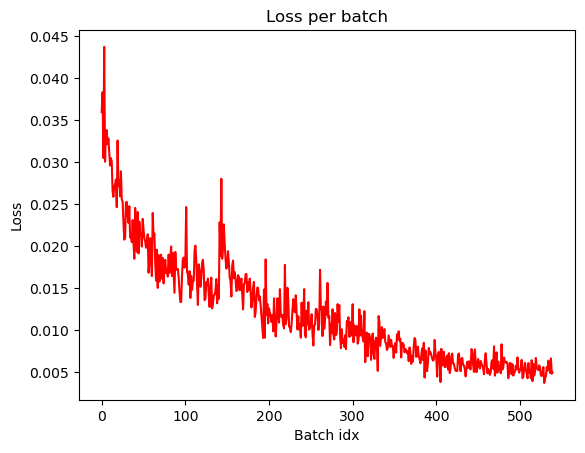

In [ ]:
import matplotlib.pyplot as plt 

plt.title("Loss per batch") 
plt.xlabel("Batch idx") 
plt.ylabel("Loss") 
plt.plot(list(range(0,len(loss_per_batch))),loss_per_batch , color ="red") 
plt.show()

In [ ]:
model.eval()

AeBasedMLP(
  (encoder): Encoder(
    (input): Linear(in_features=18000, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=2048, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (input): Linear(in_features=2048, out_features=4096, bias=True)
    (layer_1): Linear(in_features=4096, out_features=4096, bias=True)
    (layer_2): Linear(in_features=4096, out_features=30, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'selected_antibiotics': driams.selected_antibiotics
            }, './modelTrainedOnlyOnB.pt')